# cml1 - Immobilienrechner
# 3. Klassifikation des Objekttyps

Entwickle und vergleiche drei sinnvolle Modelle zur Klassifikation von Immobilien-Objekten hinsichtlich `type`.

Was sind sinnvolle Metriken zur Messung der Genauigkeit der Vorhersage im vorliegenden Fall? Was ist zu beachten, um eine gute Abschätzung des Fehlers für neue Daten zu bekommen?

Rapportiere diese Metrik(en) mit einer Abschätzung des Fehlers für alle drei Modelle.

Abgabe

Notebook und daraus erstellter Bericht (ohne Code) als pdf.

## Module importieren

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
from sklearn.pipeline import Pipeline

## Daten laden
Zuerst laden wir Ihre Daten und bereiten sie für das Training vor. Dazu gehört das Behandeln von fehlenden Werten, das Umwandeln kategorischer Daten in numerische Werte und das Skalieren der Daten.

In [94]:
df_raw = pd.read_csv('../../data/immo_data_clean.csv', low_memory=False)
print(df_raw.shape)

(21466, 57)


## Datenanalyse

In diesem Bereich ist es das Ziel, Das Zusammenführen ähnlicher Immobilienarten systematisch zu untersuchen.


In [95]:
df_raw["type_unified"].isna().sum()

0

Die Spalte `type_unified` enthält keine Null-Werte.

In [96]:
df_raw['type_unified'].value_counts()

type_unified
flat                              10511
detached-house                     5164
villa                              1163
semi-detached-house                 818
duplex-maisonette                   686
attic-flat                          674
chalet                              665
penthouse                           622
terrace-house                       497
stepped-apartment                   206
farmhouse                           152
studio                               95
rustico                              64
stepped-house                        57
loft                                 42
furnished-residential-property       24
attic-room                           12
castle                                6
detached-secondary-suite              4
single-room                           3
secondary-suite                       1
Name: count, dtype: int64

#### Zusammenführung von Kategorien
Ähnliche Kategorien gruppieren: Sie könnten Kategorien zusammenführen, die ähnliche Merkmale oder Eigenschaften haben. Zum Beispiel:
- attic-flat und penthouse könnten zu einer Kategorie wie luxury-flats zusammengeführt werden.
- semi-detached-house und duplex-maisonette könnten zu einer Kategorie wie semi-detached-duplex kombiniert werden.
- chalet, rustico und farmhouse könnten zu einer Kategorie wie rural-properties zusammengefasst werden.

In [97]:
# attic-flat und penthouse -> luxury-flats
df_raw['type_unified'] = df_raw['type_unified'].replace(['attic-flat', 'penthouse', 'loft'], 'luxury-flat')

# semi-detached-house und duplex-maisonette -> semi-detached-duplex
df_raw['type_unified'] = df_raw['type_unified'].replace(['semi-detached-house', 'duplex-maisonette'], 'semi-detached-duplex')

# farmhouse und rustico -> rural-property
df_raw['type_unified'] = df_raw['type_unified'].replace(['farmhouse', 'rustico'], 'rural-property')

# stepped-house to detached-house 
df_raw['type_unified'] = df_raw['type_unified'].replace('stepped-house', 'detached-house')

# studio to flat
df_raw['type_unified'] = df_raw['type_unified'].replace('studio', 'flat')

In [98]:
# Identifizieren der Typen mit einer Anzahl von weniger als 20, außer 'castle'
types_to_replace = df_raw['type_unified'].value_counts()[(df_raw['type_unified'].value_counts() < 50) & (df_raw['type_unified'].value_counts().index != 'castle')].index.tolist()

# Ersetzen dieser Typen durch "other"
df_raw['type_unified'] = df_raw['type_unified'].replace(types_to_replace, 'other')


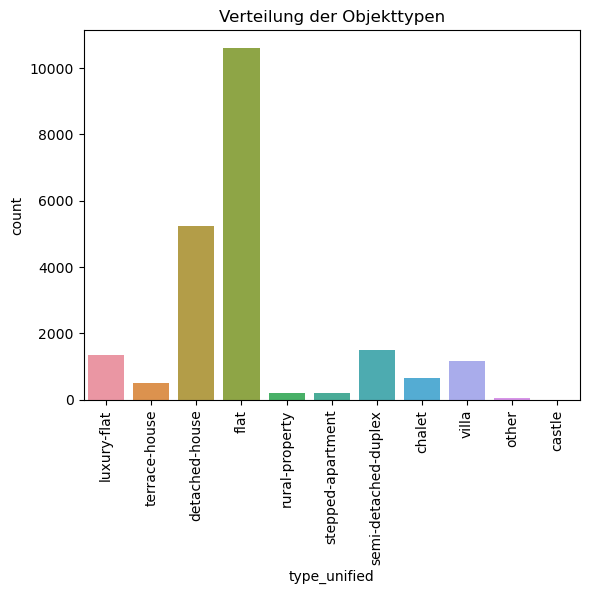

In [99]:
sns.countplot(x='type_unified', data=df_raw)
plt.title('Verteilung der Objekttypen')
plt.xticks(rotation=90)
plt.show()

## Vorverarbeitung

- Daten in Train - und Testsplit aufteilen
- Numerische Daten skalieren und kategorische Daten umwandeln

### Train Test Split

In [100]:
X = df_raw.drop('type_unified', axis=1)
y = df_raw['type_unified']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17172, 56), (4294, 56), (17172,), (4294,))

In [101]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

In [102]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Metriken

Folgende Metriken zur Messung der Genauigkeit eines Klassikiationsmodells sind geeignet:

1. Accuracy: Der Anteil der insgesamt korrekt klassifizierten Objekte.

2. Precision und Recall: Precision misst, wie viele der als einer Klasse zugeordneten Objekte tatsächlich zu dieser Klasse gehören, während Recall misst, wie viele Objekte einer Klasse korrekt identifiziert wurden.

3. F1-Score: Der harmonische Mittelwert aus Precision und Recall.

4. Konfusionsmatrix: Zeigt die Anzahl der korrekten und falschen Vorhersagen für jede Klasse.

Wir werden die Accuracy und den F1-Score verwenden, um die Leistung unserer Modelle zu messen.

## Beachtung für eine gute Fehlerabschätzung

1. Vermeidung von Overfitting: Um Overfitting zu vermeiden, stellen wir sicher, dass unser Modell nicht nur auf den Trainingsdaten gut funktioniert, sondern auch auf neuen, unbekannten Daten. 

2. Cross-Validation: Wir verwenden Kreuzvalidierung, um eine bessere Schätzung der Modellleistung zu erhalten. 

3. Ausgewogenheit der Klassen: Ausserdem achten wir darauf, dass unser Datensatz keine starke Unausgewogenheit in den Klassen aufweist, da dies zu verzerrten Vorhersagen führen kann. 

4. Feature-Importance: Schliesslich analysieren wir, welche Merkmale am meisten zur Klassifizierung beitragen, um die Feature-Importance zu verstehen.

## Modellierung

Wir werden drei verschiedene Modelle verwenden, um die Immobilienobjekte zu klassifizieren:

1. MLP

2. Logistic Regression

3. Random Forest Classifier

4. Support Vector Machine

### 1. Multi Layer Perceptron
#### 1.1 Modell trainieren

In [103]:
f1_scorer = make_scorer(f1_score, average='weighted')

param_grid = {
    'classifier__alpha': [0.0, 0.01, 0.1],
    'classifier__learning_rate_init': [0.01, 0.1],
    'classifier__max_iter': [1000],
    'classifier__hidden_layer_sizes': [(100, 50, 25), (100, 100, 100), (100, 100, 100, 100)]
}

mlp = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(random_state=42))
])

grid_search = GridSearchCV(
    mlp,
    param_grid,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Beste Parameter:", best_params)
print("Beste Score:", best_score)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/alexanderschilling/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Beste Parameter: {'classifier__alpha': 0.1, 'classifier__hidden_layer_sizes': (100, 50, 25), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 1000}
Beste Score: 0.6669399740935484


#### 1.2 Classification Report

In [105]:
print(classification_report(y_test, y_pred, zero_division=0))

                      precision    recall  f1-score   support

              castle       0.00      0.00      0.00         3
              chalet       0.64      0.44      0.52       140
      detached-house       0.63      0.79      0.70      1012
                flat       0.81      0.92      0.86      2112
         luxury-flat       0.37      0.12      0.19       289
               other       0.00      0.00      0.00        12
      rural-property       0.00      0.00      0.00        51
semi-detached-duplex       0.29      0.20      0.23       296
   stepped-apartment       0.73      0.15      0.25        52
       terrace-house       0.49      0.28      0.36        95
               villa       0.47      0.31      0.37       232

            accuracy                           0.70      4294
           macro avg       0.40      0.29      0.32      4294
        weighted avg       0.66      0.70      0.67      4294



#### 1.3 Confusion Matrix

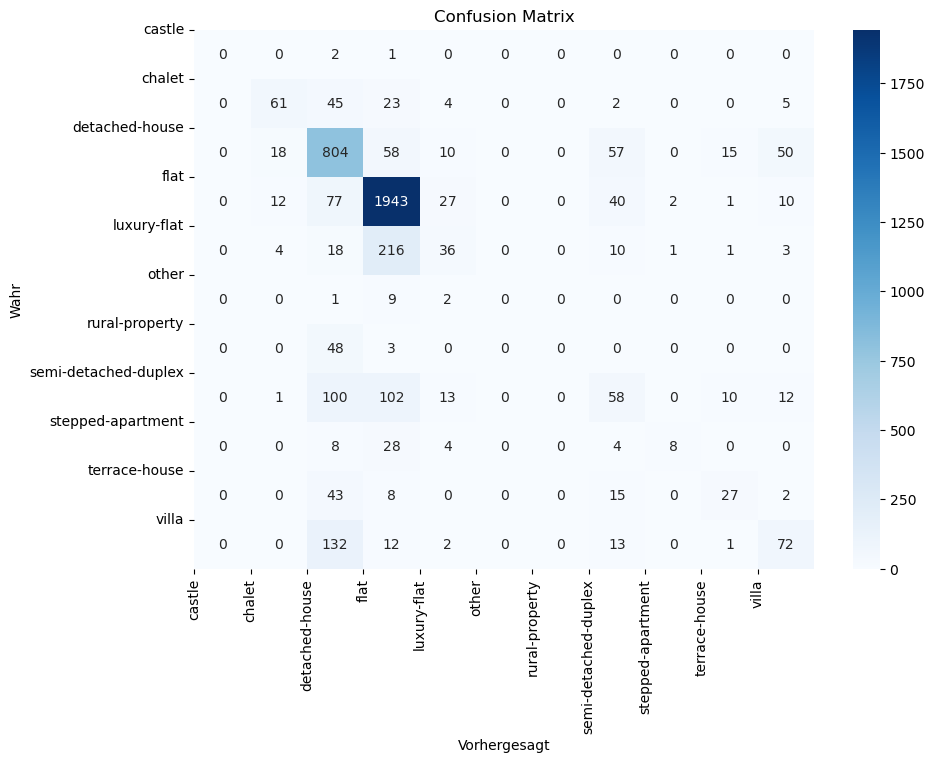

In [106]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Vorhergesagt')
plt.ylabel('Wahr')
plt.title('Confusion Matrix')
plt.xticks(ticks=range(len(grid_search.classes_)), labels=grid_search.classes_, rotation=90)
plt.yticks(ticks=range(len(grid_search.classes_)), labels=grid_search.classes_, rotation=0)
plt.show()

- Accuracy: 0.67
- F1-Score: 0.64

Wir sehen, dass hauptsächlich die häufigste Klassen vorhergesagt wird.

### 2. Logistic Regression
#### 2.1 Modell trainieren

In [109]:
from sklearn.linear_model import LogisticRegression

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__max_iter': [1000, 2000, 3000]
}

logistic_regression_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

grid_search = GridSearchCV(
    logistic_regression_pipeline,
    param_grid,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Beste Parameter:", best_params)
print("Beste Score:", best_score)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/alexanderschilling/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/alexanderschilling/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/alexanderschilling/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_it

Beste Parameter: {'classifier__C': 10, 'classifier__max_iter': 2000, 'classifier__penalty': 'l2'}
Beste Score: 0.5657192865014735


In [110]:
print("Beste Parameter:", best_params)
print("Beste Score:", best_score)

Beste Parameter: {'classifier__C': 10, 'classifier__max_iter': 2000, 'classifier__penalty': 'l2'}
Beste Score: 0.5657192865014735
